## Analyzing morphology from the z-stack images
- Collects height from the difference of top

In [1]:
%matplotlib notebook

# Dependencies
import xml.etree.ElementTree as ET
import numpy as np
import glob
import cv2
import sys
import pandas as pd

import colony_iomethods as cm
import tracker as tr

from matplotlib import pyplot as plt

In [13]:
# Folder for the files
exp_name = "EQ59_01072021_12am"
# acq_name = "Interval12-36h_10pm"
acq_name = "First12h"

# base_folder = f"C:/Users/Tolga/Dropbox/GitHub/colony-image-analysis/{exp_name}/{acq_name}/"
base_folder = f"D:/Tolga/Colony Images/{exp_name}/{acq_name}/"

# Replace the metadata_path with
metadata_path = base_folder + f"MetaData/{exp_name}_{acq_name}_Properties.xml"

tree = ET.parse(metadata_path)    # xml tree of the current stage position
root = tree.getroot()           # root of the xml tree

image_xml = root[0]

# Video folder
video_folder = base_folder + "Videos_Unmarked/"
# Data folder for analysis:
resource_folder = base_folder + "Resources/"
csv_path = resource_folder + f"{acq_name}_Movie.csv"

In [14]:
# Collect information from the xml
dim_desc = cm.collectImageDim(image_xml)
xsz = dim_desc["xsz"]
ysz = dim_desc["ysz"]
zsz = dim_desc["zsz"]
xvoxel = dim_desc["xvoxel"]
yvoxel = dim_desc["yvoxel"]
zvoxel = dim_desc["zvoxel"]
xunit = dim_desc["xunit"]
yunit = dim_desc["yunit"]
zunit = dim_desc["zunit"]

# Tilescan info
tilescan_desc = cm.collectTileScan(image_xml)
xixar = tilescan_desc["xix_unique_ar"]
yixar = tilescan_desc["yix_unique_ar"]

tilescan is set


In [15]:
# Go through each timepoint and each frame to collect the pixel and their locations that exceeds the threshold
def get_image_sequence(video_folder, acq_name, t_str):
    # Run through a single timepoint
    video_path = video_folder + f"{acq_name}_{t_str}.avi"

    # Video capture object
    vidcap = cv2.VideoCapture(video_path)

    # Frame properties
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))

    img_seq = np.zeros((frame_height, frame_width, frame_count))
    for fix in range(frame_count):
        # Read frmae
        success,frame = vidcap.read()
        # Convert to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img_seq[:,:,fix] = frame_gray
        
    return img_seq

# frame info from test file

t_str = "t06"
video_path = video_folder + f"{acq_name}_{t_str}.avi"
vidcap = cv2.VideoCapture(video_path)

# Frame properties
frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))

In [16]:
# For z-stack averaging the noisy data.
def window(size):
    return np.ones(size)/float(size)

window_average = 5

In [17]:
zar = np.arange(0,frame_count)
tar = np.arange(0,13)

roi_width = 220
roi_height = frame_height
centerx = 126
centery = 303

# Calculate background average, and find the bottom
corner_mean = np.zeros((len(zar), len(tar)))
zbottom = np.zeros(len(tar))
for tix in range(len(tar)):
    t_str = "t%02d" % tar[tix]
    print(t_str, end="   \r")
    img_seq = get_image_sequence(video_folder, acq_name, t_str)
    for zix in range(len(zar)):
        corner_img = img_seq[:,:, zix]
        corner_mean[zix, tix] = corner_img.mean()
    corner_conv = np.convolve(corner_mean[:,tix], window(window_average), mode="same")
    zbottom[tix] = zar[np.argmax(corner_conv)]

In [24]:
colony_height = np.zeros((roi_width, len(tar)))
for tix in range(len(tar)):
    t_str = "t%02d" % tix
    topval_img = cv2.imread(resource_folder + f"height_{t_str}.tif", cv2.IMREAD_GRAYSCALE)
    height_img = topval_img - zbottom[tix]

    # Set the negative values to zero
    height_img[height_img < 0] = 0
    colony_height[:,tix] = height_img[centery, :]

<IPython.core.display.Javascript object>


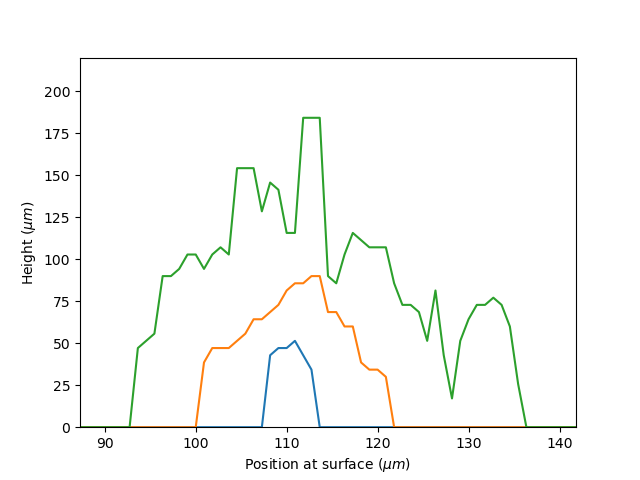

Text(0, 0.5, 'Height $(\\mu m)$')

In [39]:
fig, ax = plt.subplots(1,1)

ax.plot(np.arange(0,roi_width)*xvoxel, -colony_height[:,5]*zvoxel,
        np.arange(0,roi_width)*xvoxel, -colony_height[:,7]*zvoxel,
        np.arange(0,roi_width)*xvoxel, -colony_height[:,9]*zvoxel)
ax.set_xlim((centerx-30)*xvoxel, (centerx+30)*xvoxel)
ax.set_ylim(0,220)
ax.set_xlabel(r"Position at surface $(\mu m)$")
ax.set_ylabel(r"Height $(\mu m)$")